## House Pricing - Model Selection & Tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
from IPython.display import display, HTML

In [2]:
def display_scrollable_df(df, *, title="DataFrame"):
    style = f"""
    <style>
    .scrollable-table {{ 
        overflow-y: auto; 
        height: 400px; 
        border: 1px solid #ddd; 
        padding: 8px; 
    }}
    </style>
    """
    scrollable_div = f"""
    <h3>{title}</h3>
    <div class='scrollable-table'>{df.to_html()}</div>
    """
    
    display(HTML(style + scrollable_div))

### Loading the data

In [3]:
df_categorical = pd.read_csv("./data/categorical_train.csv")
df_numerical = pd.read_csv("./data/numerical_train.csv")
df = pd.concat([df_categorical, df_numerical], axis=1)

In [4]:
display_scrollable_df(df.describe().T, title="DataFrame Info")
df.shape

,count,mean,std,min,25%,50%,75%,max
MSZoning,1460.0,2.714384,0.795764,0.0,3.00,3.000000,3.00,4.0
Street,1460.0,0.995890,0.063996,0.0,1.00,1.000000,1.00,1.0
Alley,1460.0,1.903425,0.394776,0.0,2.00,2.000000,2.00,2.0
LotShape,1460.0,0.429452,0.653841,0.0,0.00,0.000000,1.00,3.0
LandContour,1460.0,1.050000,0.449926,0.0,1.00,1.000000,1.00,3.0
Utilities,1460.0,0.999315,0.026171,0.0,1.00,1.000000,1.00,1.0
LotConfig,1460.0,0.658219,1.172699,0.0,0.00,0.000000,1.00,4.0
LandSlope,1460.0,0.062329,0.276232,0.0,0.00,0.000000,0.00,2.0
Neighborhood,1460.0,11.973973,6.425884,0.0,6.00,12.000000,16.00,24.0
Condition1,1460.0,3.786301,1.004215,0.0,4.00,4.000000,4.00,8.0


(1460, 82)

### Visualizing the Target Variable

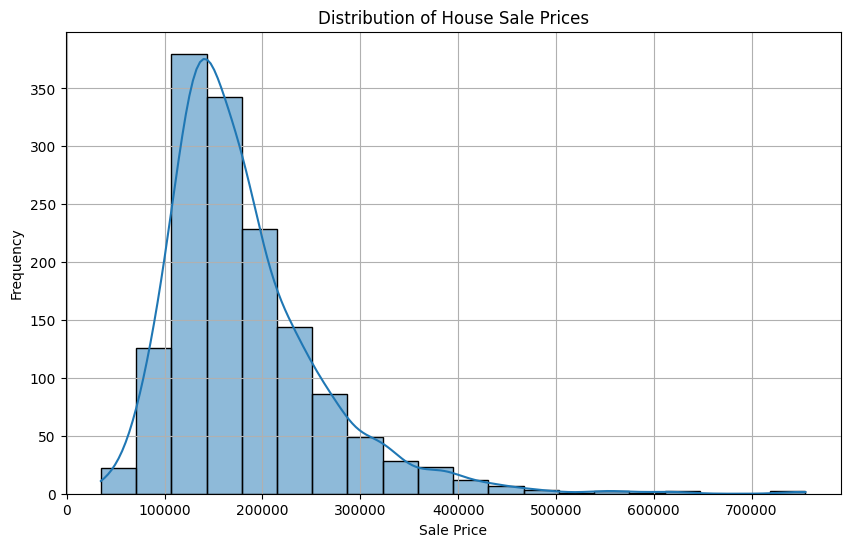

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], bins=20, kde=True)
plt.title('Distribution of House Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


<h3>Selecting features</h3>

In [6]:
df.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'Id', 'MSSubClass', 'LotFrontage',
       'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRms

In [7]:
df_corr = df.corr().abs()
display_scrollable_df(pd.concat([df_corr['SalePrice'].sort_values(ascending=False)], axis=1), title="Correlations with the SalePrice")

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
Neighborhood,0.696882
ExterQual,0.682639
KitchenQual,0.659600
GarageCars,0.640409
GarageArea,0.623431
BsmtQual,0.622925
TotalBsmtSF,0.613581


In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

low_corr_feats = df_corr['SalePrice'][(df_corr['SalePrice'] < 0.2)].index.tolist()
df_2 = df.copy(True)

cv_all = cross_val_score(RandomForestRegressor(), df_2.loc[:, df_2.columns != 'SalePrice'].values, df_2.loc[:, 'SalePrice'].values)
df_2.drop(columns=low_corr_feats, inplace=True)
cv_edited = cross_val_score(RandomForestRegressor(), df_2.loc[:, df_2.columns != 'SalePrice'].values, df_2.loc[:, 'SalePrice'].values)

print("Scores including the low corr feats:", cv_all)
print("Scores without the low corr feats", cv_edited)

if (cv_all.mean() < cv_edited.mean()):
    print("We should remove the low corr feats")
else:
    print("We should keep the low corr feats")

Scores including the low corr feats: [0.89647092 0.8463468  0.87724918 0.88866305 0.81156356]
Scores without the low corr feats [0.89071953 0.83620589 0.87729376 0.89339776 0.83941438]
We should remove the low corr feats


In [9]:
df.drop(columns=low_corr_feats, inplace=True)

In [10]:
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'SalePrice'].values
y = df.loc[:, 'SalePrice'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

### Training the models

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

regressors = []
regressors.append(RandomForestRegressor())
regressors.append(LinearRegression())
regressors.append(DecisionTreeRegressor())
regressors.append(XGBRegressor())

for model in regressors:
    print(type(model), 'has begun the training!')
    model.fit(X_train, y_train)
    print(type(model), 'has ended the training!\n')

<class 'sklearn.ensemble._forest.RandomForestRegressor'> has begun the training!
<class 'sklearn.ensemble._forest.RandomForestRegressor'> has ended the training!

<class 'sklearn.linear_model._base.LinearRegression'> has begun the training!
<class 'sklearn.linear_model._base.LinearRegression'> has ended the training!

<class 'sklearn.tree._classes.DecisionTreeRegressor'> has begun the training!
<class 'sklearn.tree._classes.DecisionTreeRegressor'> has ended the training!

<class 'xgboost.sklearn.XGBRegressor'> has begun the training!
<class 'xgboost.sklearn.XGBRegressor'> has ended the training!



### Evaluating the models

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for model in regressors:
    y_pred = model.predict(X_test)

    print(type(model))
    print("MAE", mean_absolute_error(y_test, y_pred))
    print("MSE", mean_squared_error(y_test, y_pred))
    print("R2", r2_score(y_test, y_pred), '\n')


<class 'sklearn.ensemble._forest.RandomForestRegressor'>
MAE 18159.973664383564
MSE 1030493148.9007735
R2 0.7963321316136652 

<class 'sklearn.linear_model._base.LinearRegression'>
MAE 22252.512708637918
MSE 2041952643.1521723
R2 0.5964260969417758 

<class 'sklearn.tree._classes.DecisionTreeRegressor'>
MAE 27416.36301369863
MSE 2054552947.2465754
R2 0.5939357581378117 

<class 'xgboost.sklearn.XGBRegressor'>
MAE 17024.70288420377
MSE 717177622.0709596
R2 0.8582561779305556 



### Tuning the hyperparameters

In [13]:
from sklearn.model_selection import GridSearchCV

#### Random Forest Regressor

In [17]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
}

random_forest = RandomForestRegressor(random_state=43)
rf_grid_search = GridSearchCV(estimator=random_forest, param_grid=rf_params, scoring='r2', cv=5, verbose=1)
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=43),
             param_grid={'max_depth': [None, 20, 30],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='r2', verbose=1)

In [18]:
rf_grid_search.best_params_

{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

In [20]:
rf_grid_search.best_score_

0.8482569214632217

#### XGB Regressor

In [22]:
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 30],
    'learning_rate': [0.01, 0.1, 0.15]
}

xgb = XGBRegressor()
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_params, scoring='r2', cv=5, verbose=1)
xgb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.15],
                         'max_depth': [None, 20, 30],
                         'n_estimators': [100, 200]},
             scoring='r2', verbose=1)

In [23]:
xgb_grid_search.best_params_

{'learning_rate': 0.15, 'max_depth': None, 'n_estimators': 100}

In [24]:
xgb_grid_search.best_score_

0.8470558220403381

### Training after tuning

In [25]:
rf = RandomForestRegressor(max_depth=20, min_samples_split=2, n_estimators=200)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("R2", r2_score(y_test, y_pred))

MAE 18104.400465967778
MSE 956430617.1332684
R2 0.8109699368125385


In [26]:
xgb = XGBRegressor(learning_rate= 0.15, max_depth= None, n_estimators= 100)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("R2", r2_score(y_test, y_pred))

MAE 16315.766200235445
MSE 672867534.5069755
R2 0.8670136753402132


### Conclusion
Both the ***RandomForestRegressor*** & the ***XGBRegressor*** perform very well in the tests. They are quite close even after the tuning. We must admit that the XGBRegressor is a better soloution for this problem. 